<a href="https://colab.research.google.com/github/Debojit-D/ES666-CV/blob/main/22110067_ES666_Assignment_B_Where_is_the_Mystery%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

### Pre-defined code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/images/B/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 6/6 [00:00<00:00, 103.33it/s]


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

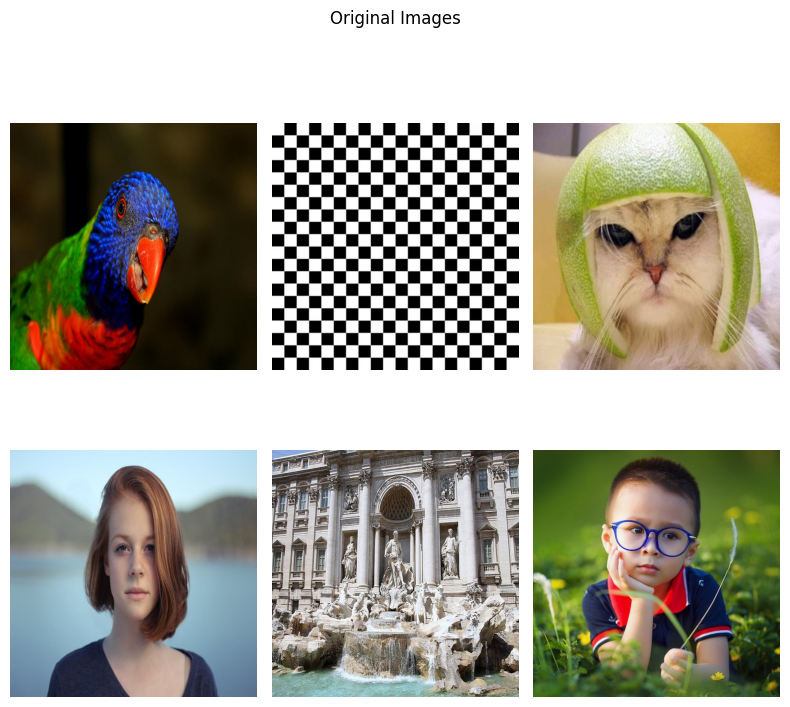

In [ ]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

### Q1 [2 Marks]

Implement Gaussian Pyramid Downsampling method from scratch.Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [ ]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [ ]:
def gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels - 1):
        # Apply Gaussian blur and downsample by a factor of 2
        blurred_image = cv2.GaussianBlur(image, (5, 5), sigmaX=1)
        # Write code here
        image = cv2.pyrDown(blurred_image)
        image = pad_image_to_divisible(image, pyramid[0].shape[0])
        pyramid.append(image)

    return np.array(pyramid)

def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        # Apply Gaussian blur and downsample by a factor of 2
        # Write code here

        image = cv2.resize(inp_image, (h//2**i, w//2**i))

        image = pad_image_to_divisible(image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

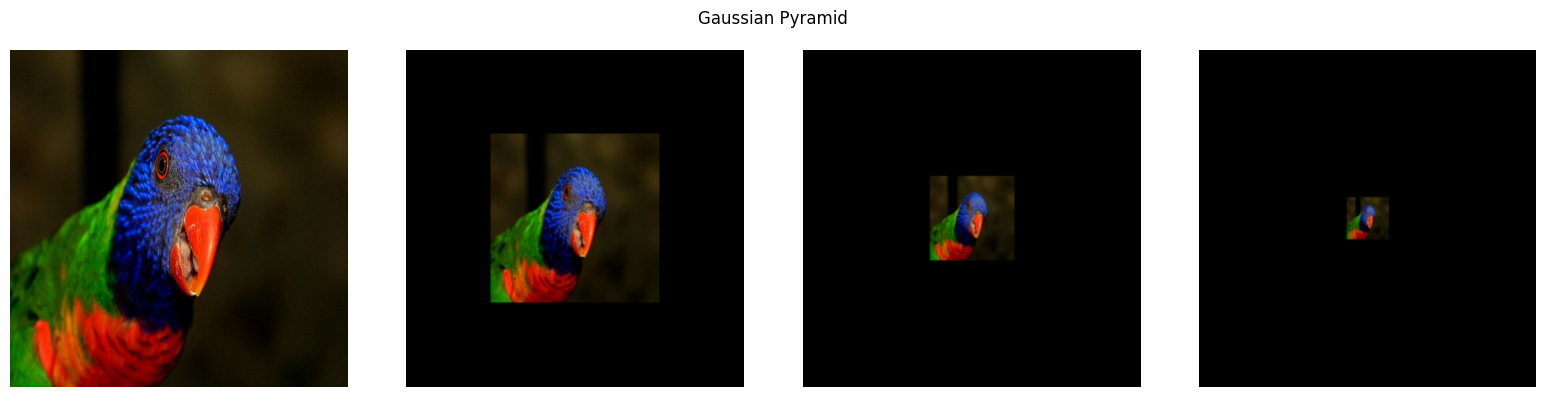

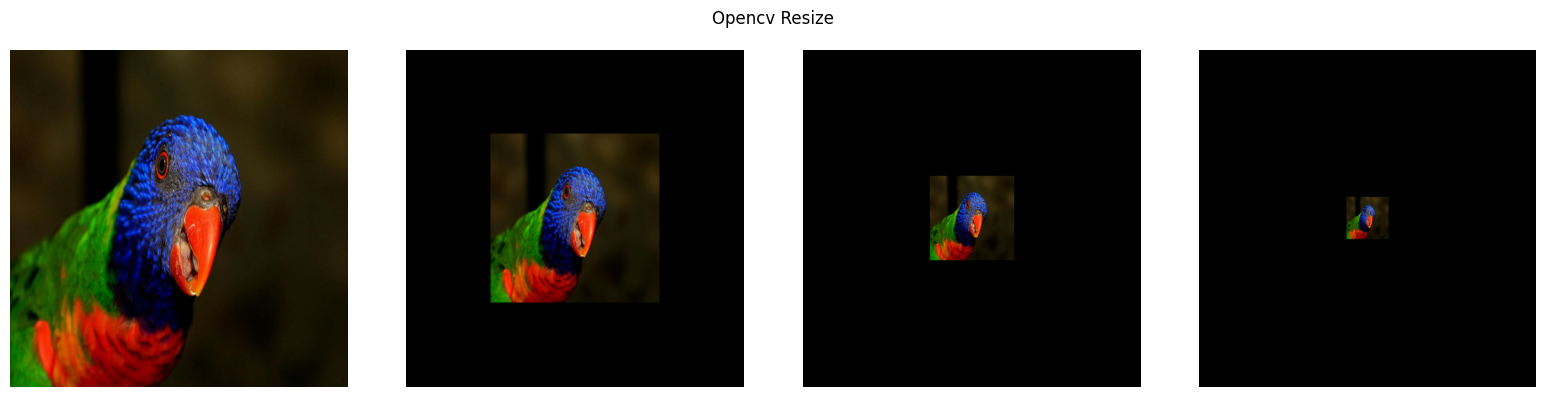

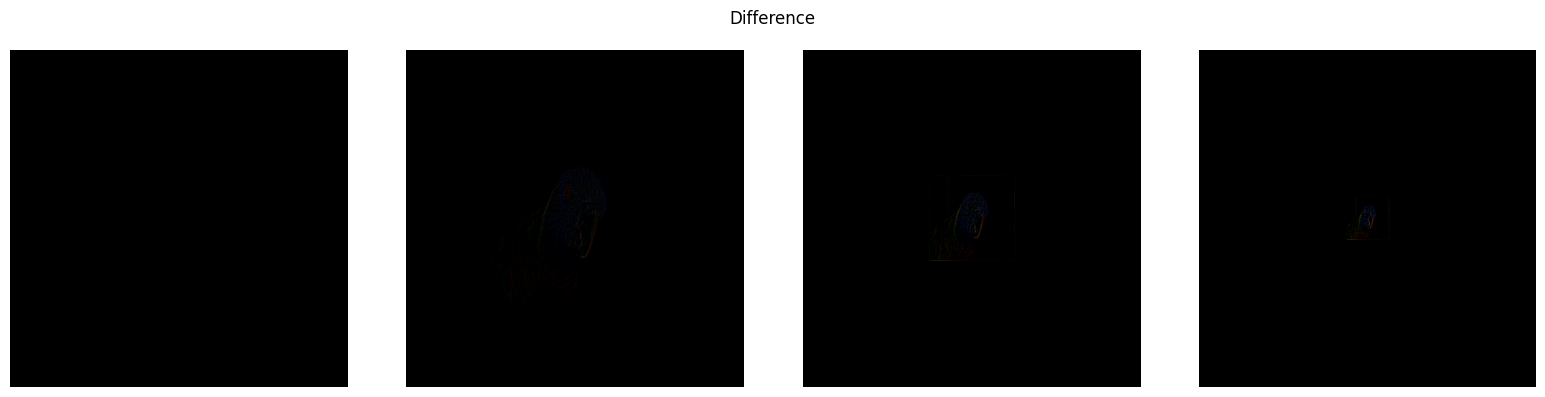

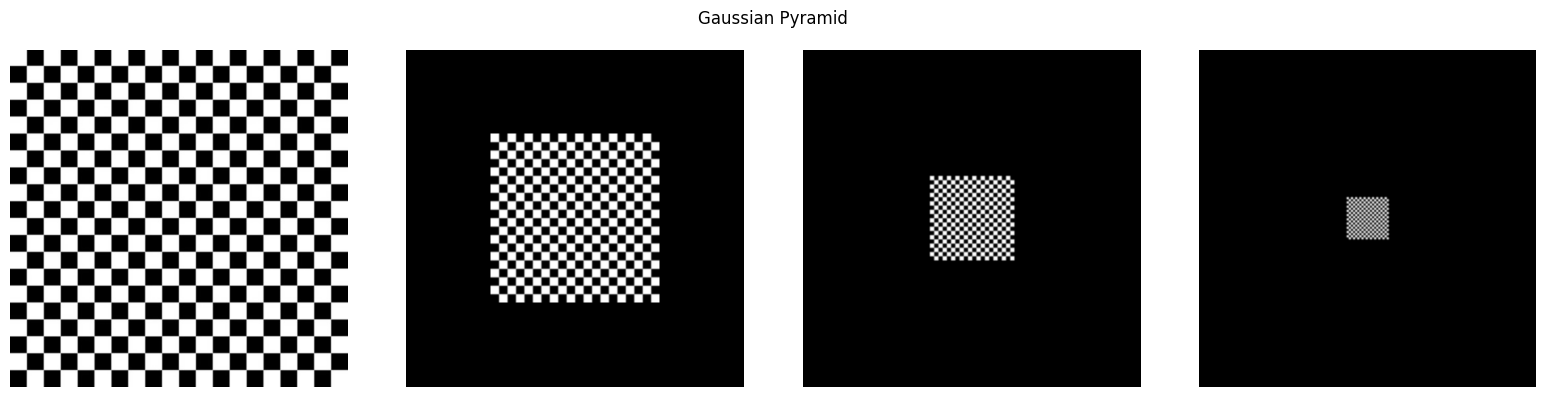

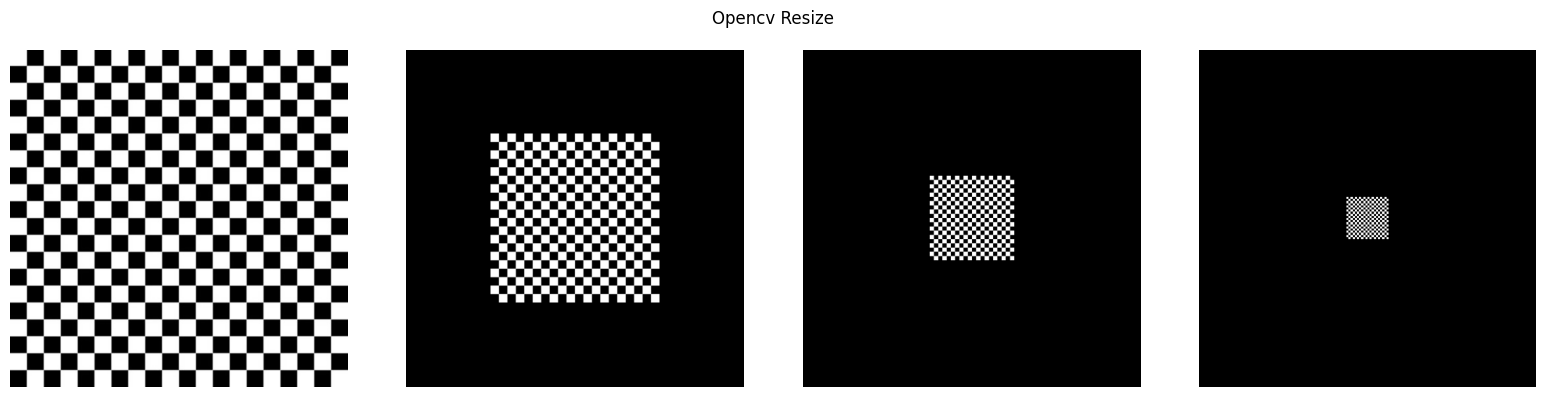

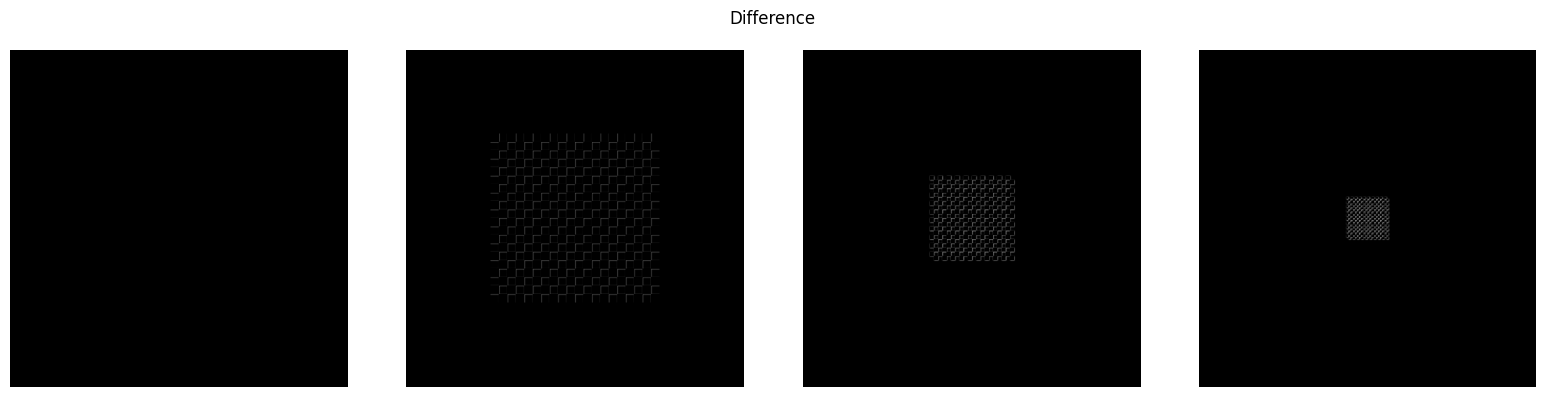

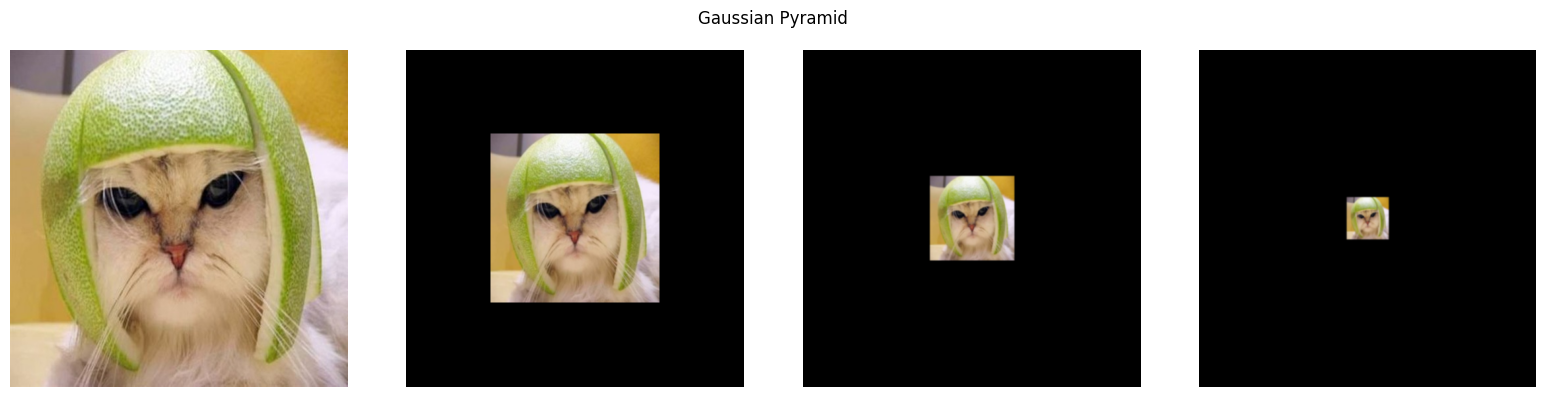

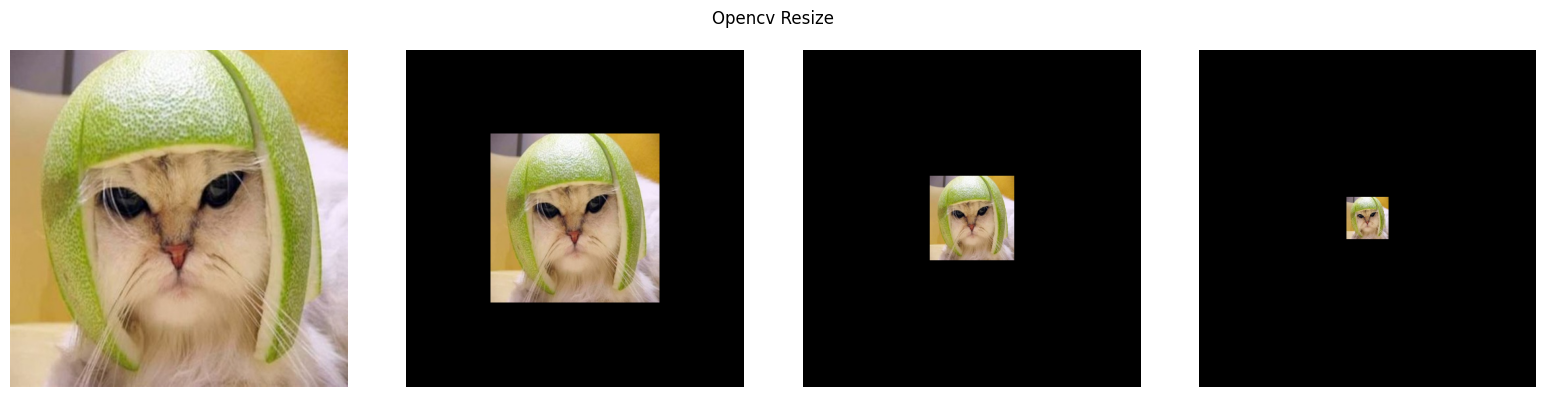

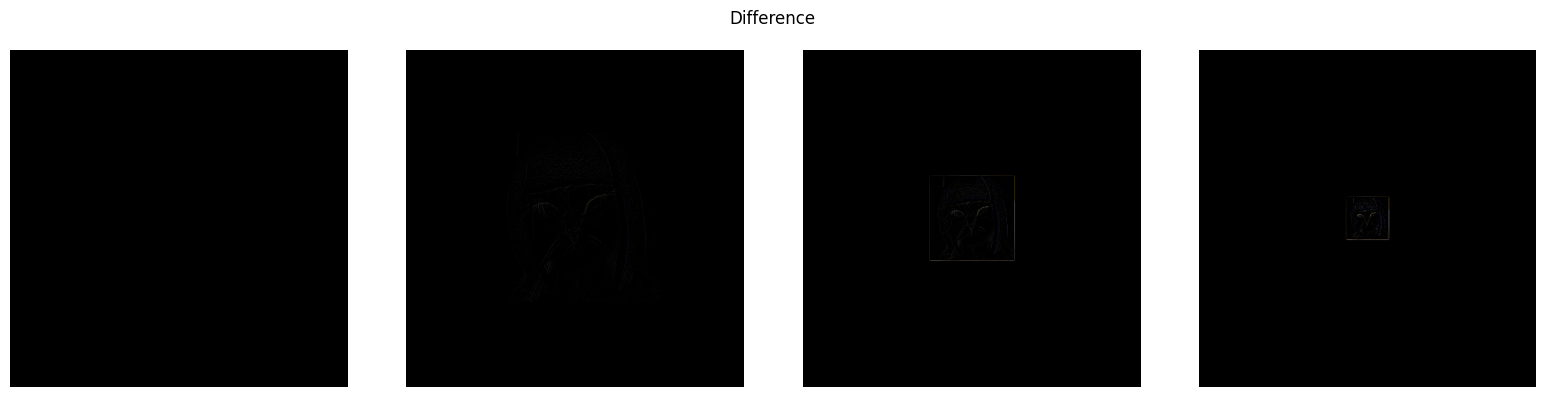

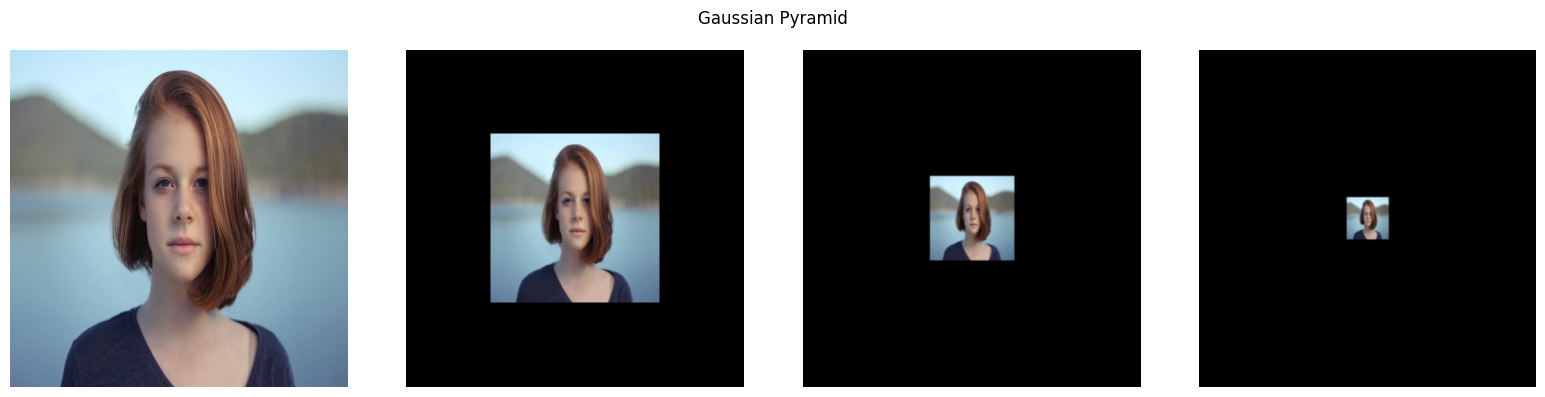

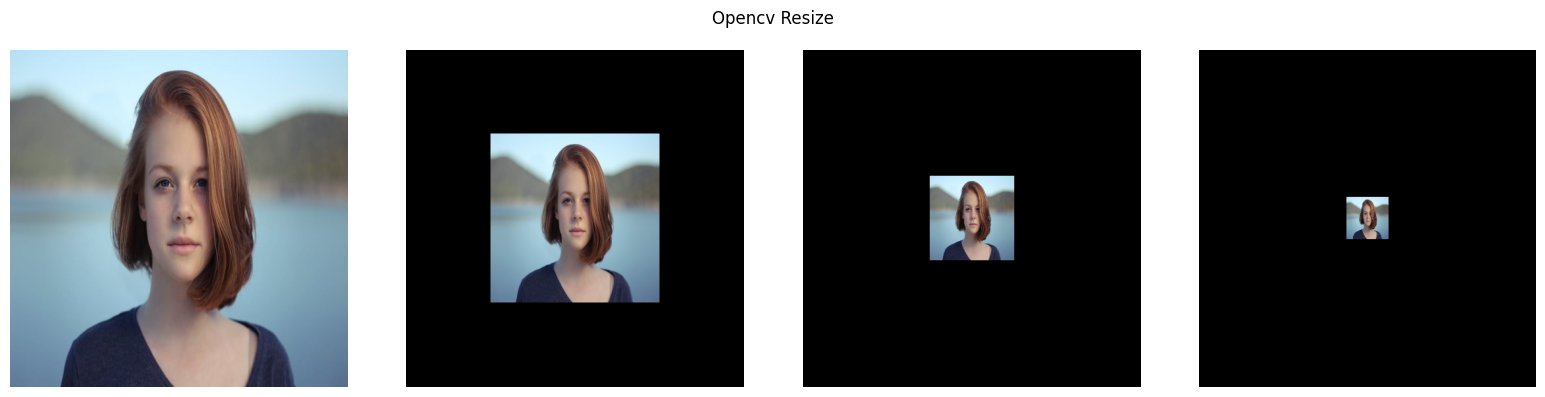

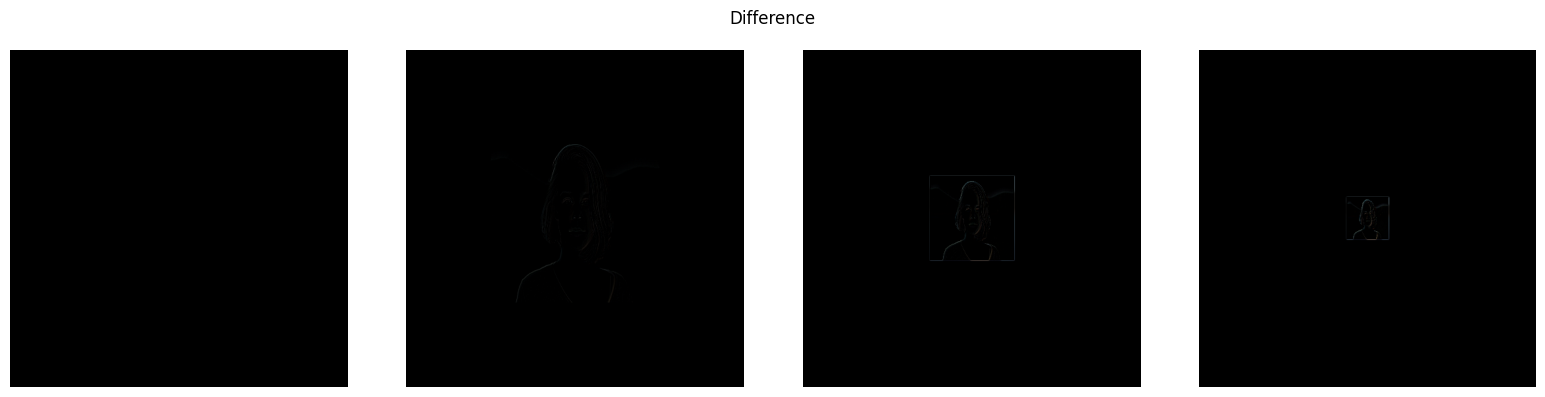

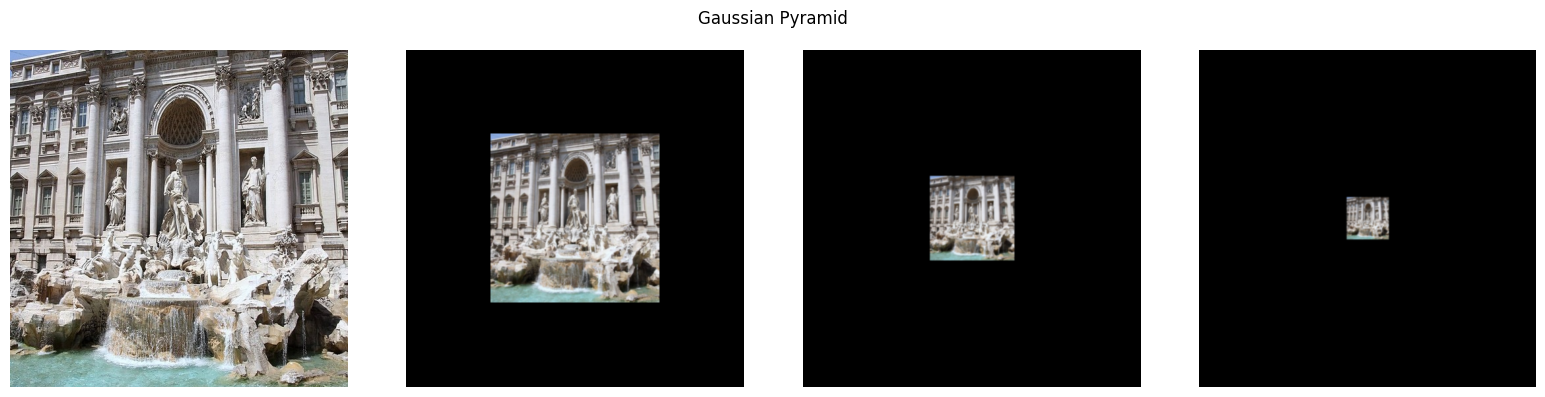

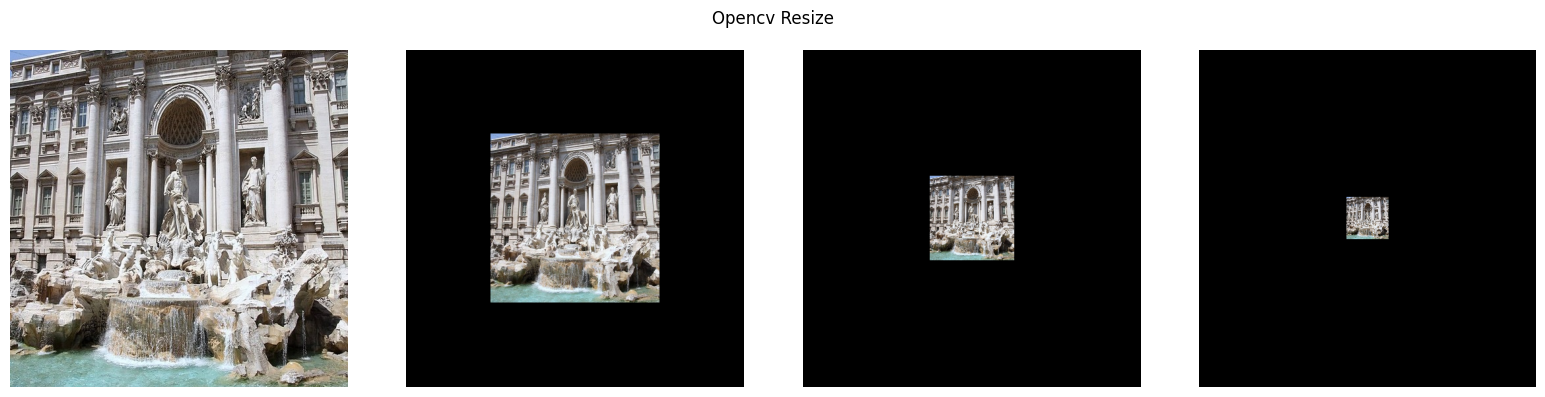

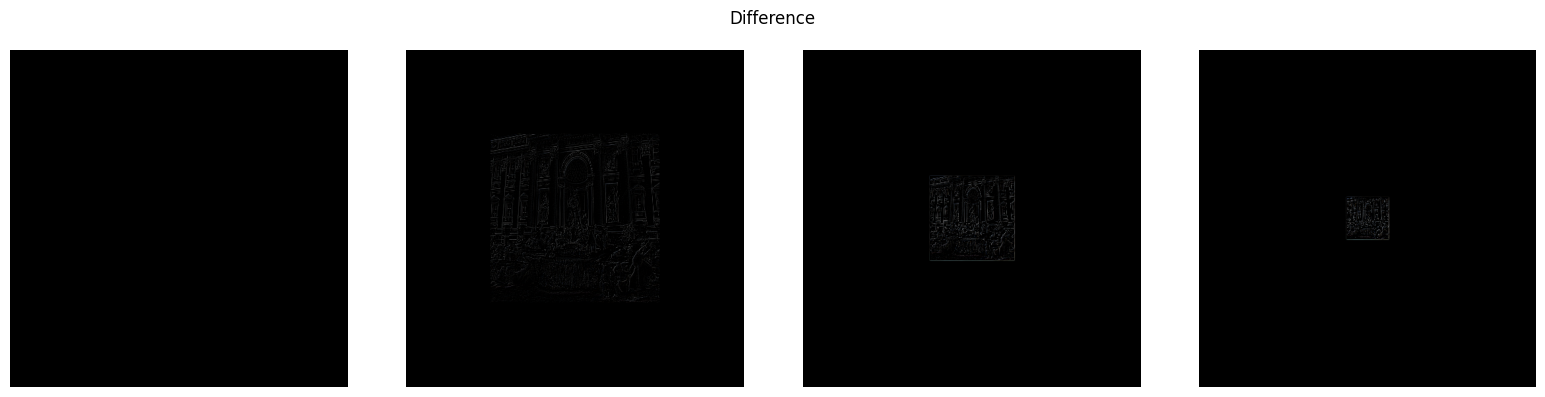

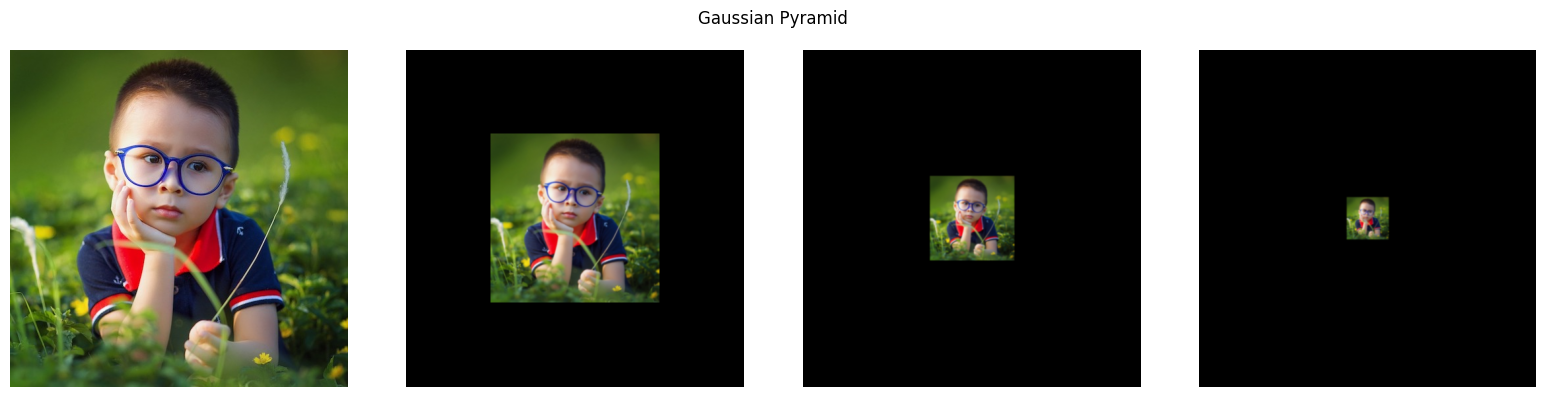

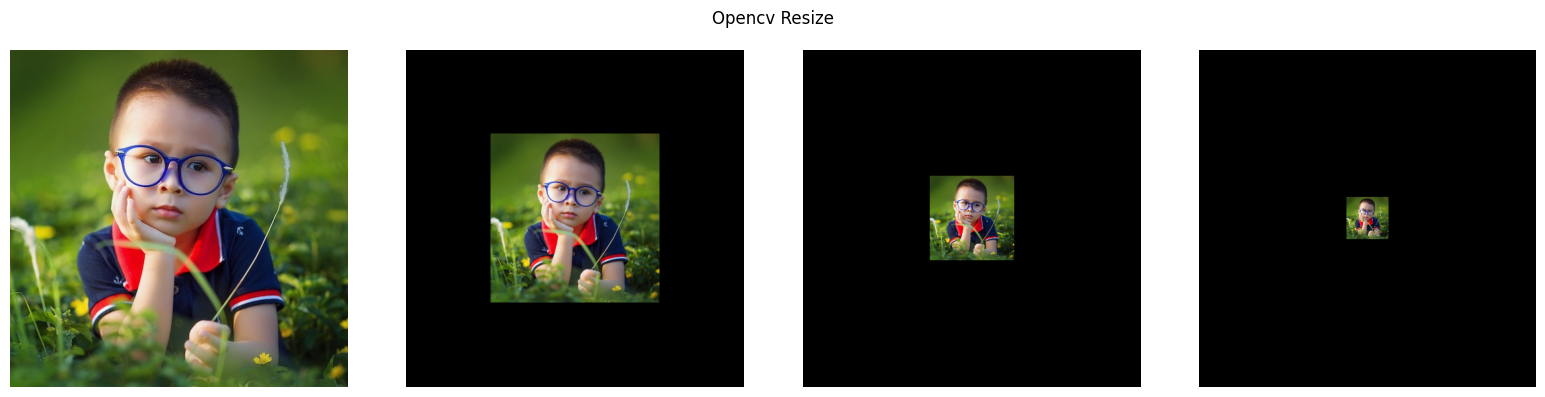

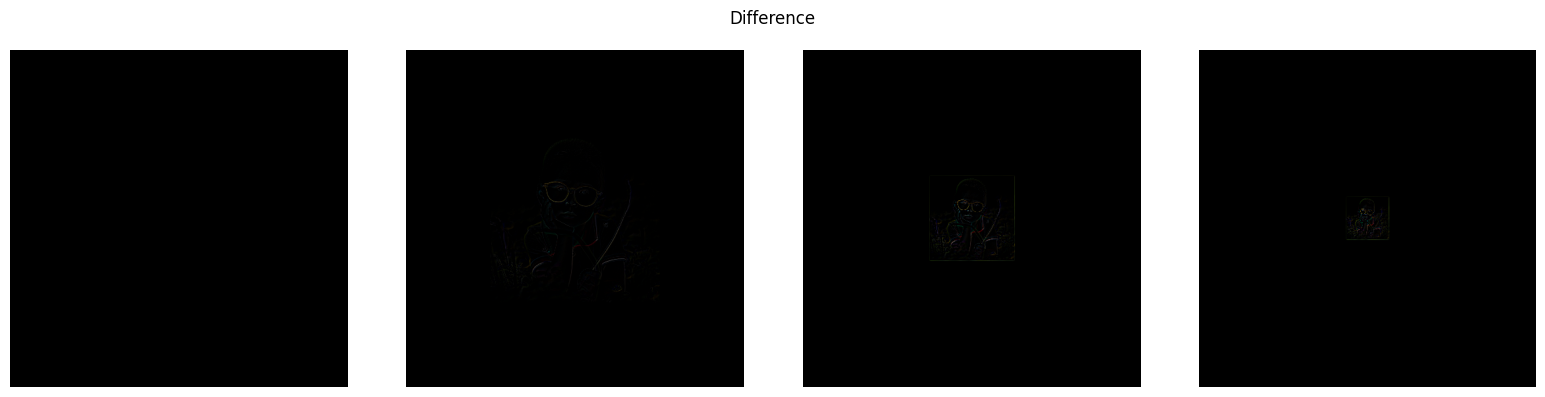

In [ ]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)


In most cases, the Gaussian Pyramid and OpenCV resize methods produce similar outputs, as indicated by the predominantly black areas in the difference plots, which signify minimal differences. This similarity is due to both methods effectively reducing image size while maintaining overall structure.

However, in images with more defined edges and corners, the differences become more noticeable. The Gaussian Pyramid method applies a smoothing effect before downsampling, leading to softer edges and less noise. In contrast, the OpenCV resize method retains sharper details due to direct interpolation. This results in slight variations around high-contrast areas, where the Gaussian Pyramid smooths out transitions more than OpenCV's approach.

This is mostly seen after the 2nd and 3rd levels of downsampling, where the cumulative smoothing effect of the Gaussian Pyramid becomes more pronounced, causing a visible softening of edges, while the OpenCV resize method continues to preserve sharper details, making the differences in high-contrast regions more evident.

### Q2 [4 Marks]

You have to implement image blending technique using Laplacian Pyramids from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Image Blending Using Laplacian Pyramids](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

In [ ]:
def gaussian_pyramid_wrapper(image, levels):
    pyramid = [image]
    for i in range(levels - 1):
        blurred_image = cv2.GaussianBlur(image, (5, 5), sigmaX=1)
        image = cv2.pyrDown(blurred_image)
        pyramid.append(image)
    return np.array(pyramid, dtype=object)


In [ ]:
def laplacian_pyramid_blend_images(image_a, image_b):
    blended_image = None
    levels = 4

    # Image Padding
    image_a = pad_image_to_divisible(image_a, 2 ** levels)
    image_b = pad_image_to_divisible(image_b, 2 ** levels)

    h, w = image_a.shape[:2]
    image_b = cv2.resize(image_b, (h, w))
    num_channels = image_a.shape[2] if len(image_a.shape) == 3 else 1
    mask = np.zeros((h, w, num_channels), dtype=np.float32)

    for i in range(w):
        if i < w // 2:
            mask[:, i] = 1.0
        else:
            mask[:, i] = 0.0

    mask = mask.astype(np.float32)

    mask_pyramid_array = gaussian_pyramid_wrapper(mask, levels)
    mask_pyramid = [mask_pyramid_array[i] for i in range(len(mask_pyramid_array))]

    def laplacian_pyramid(image, levels):
        """Generates a Laplacian pyramid for an image."""
        gaussian_pyr_array = gaussian_pyramid_wrapper(image, levels)
        gaussian_pyr = [gaussian_pyr_array[i] for i in range(len(gaussian_pyr_array))]
        laplacian_pyr = []

        for i in range(levels - 1):
            upsampled = cv2.pyrUp(gaussian_pyr[i + 1])

            laplacian = cv2.subtract(gaussian_pyr[i], upsampled)
            laplacian_pyr.append(laplacian)

        laplacian_pyr.append(gaussian_pyr[-1])
        return laplacian_pyr

    laplacian_a = laplacian_pyramid(image_a, levels)
    laplacian_b = laplacian_pyramid(image_b, levels)

    blended_pyr = []
    for la, lb, m in zip(laplacian_a, laplacian_b, mask_pyramid):
        if len(m.shape) != len(la.shape):
            m = m.reshape(m.shape[0], m.shape[1], 1)

        la = la.astype(np.float32)
        lb = lb.astype(np.float32)
        m = m.astype(np.float32)

        blended = cv2.add(cv2.multiply(m, la), cv2.multiply(1.0 - m, lb))
        blended_pyr.append(blended)

    # Reconstruct the final blended image
    def reconstruct_from_pyramid(laplacian_pyr):
        image = laplacian_pyr[-1]
        for i in range(len(laplacian_pyr) - 2, -1, -1):
            image = cv2.pyrUp(image)

            if image.shape[:2] != laplacian_pyr[i].shape[:2]:
                image = cv2.resize(image, (laplacian_pyr[i].shape[1], laplacian_pyr[i].shape[0]))

            image = cv2.add(image, laplacian_pyr[i])
        return image

    blended_image = reconstruct_from_pyramid(blended_pyr)
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)
    return blended_image


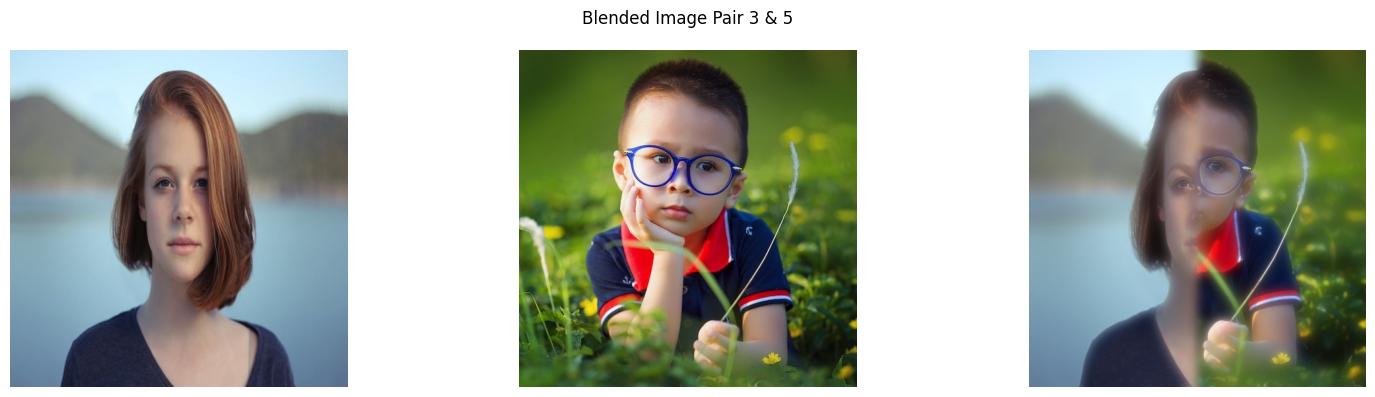

In [ ]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

### Q3 [4 Marks]

Implement Harris and Hessian Corner Detector algorithm from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Harris and Hessian Corner Detector](https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd)

In [ ]:
def detect_harris_corner(image, k=0.04, window_size=3, threshold=0.01):

    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    gray_image = np.float32(gray_image)

    # Gradients using Sobel filters
    I_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    I_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)

    # Second-order gradients
    I_x2 = I_x ** 2
    I_y2 = I_y ** 2
    I_xy = I_x * I_y

    I_x2 = cv2.GaussianBlur(I_x2, (window_size, window_size), 0)
    I_y2 = cv2.GaussianBlur(I_y2, (window_size, window_size), 0)
    I_xy = cv2.GaussianBlur(I_xy, (window_size, window_size), 0)

    det_M = I_x2 * I_y2 - I_xy ** 2
    trace_M = I_x2 + I_y2
    R = det_M - k * (trace_M ** 2)

    # Threshold and find corners
    corner_image = np.zeros_like(gray_image)
    corner_image[R > threshold * R.max()] = 255  # Threshold based on response values

    corner_image = cv2.cvtColor(corner_image.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    return corner_image


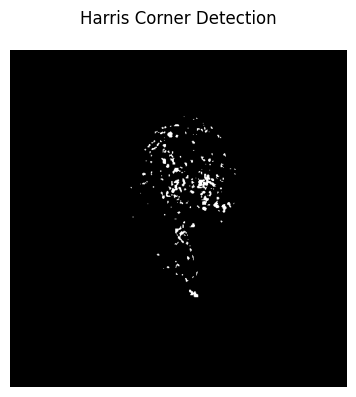

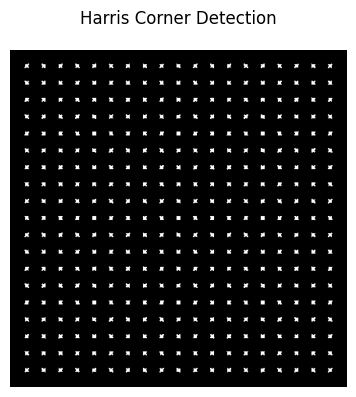

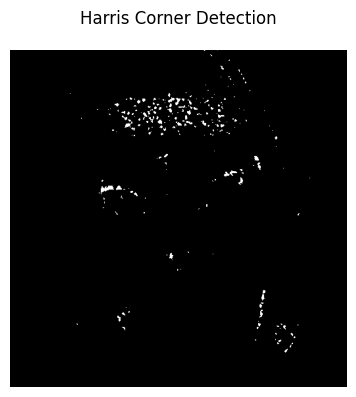

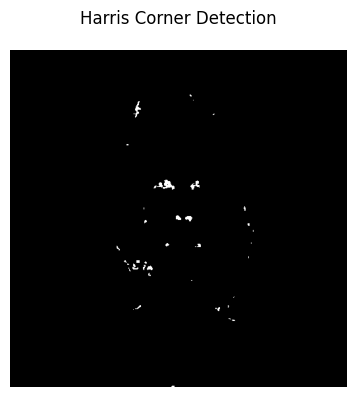

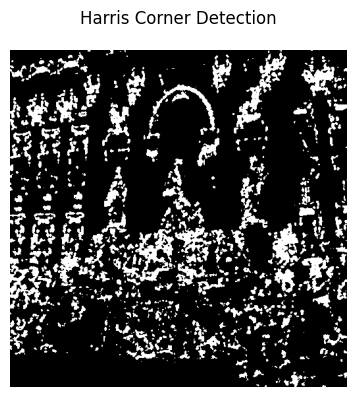

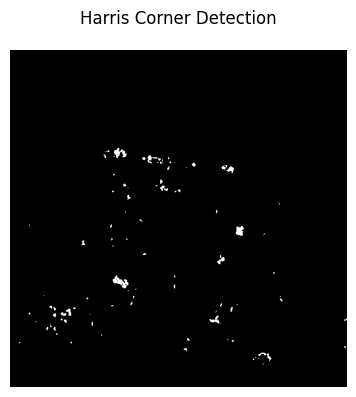

In [ ]:
for image in gt_images:
    corner_image = detect_harris_corner(image, threshold=0.01, window_size=5)
    show_image_grid(np.array([corner_image]), 1, 1, 'Harris Corner Detection', figsize=16)


In [ ]:
def detect_hessian_corner(image, threshold=0.01, window_size=3):
    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    gray_image = np.float32(gray_image)

    # Second-order gradients using Sobel filters (Hessian matrix components)
    I_xx = cv2.Sobel(gray_image, cv2.CV_64F, 2, 0, ksize=3)
    I_yy = cv2.Sobel(gray_image, cv2.CV_64F, 0, 2, ksize=3)
    I_xy = cv2.Sobel(gray_image, cv2.CV_64F, 1, 1, ksize=3)

    I_xx = cv2.GaussianBlur(I_xx, (window_size, window_size), 0)
    I_yy = cv2.GaussianBlur(I_yy, (window_size, window_size), 0)
    I_xy = cv2.GaussianBlur(I_xy, (window_size, window_size), 0)

    det_H = I_xx * I_yy - I_xy ** 2
    trace_H = I_xx + I_yy

    R = det_H - threshold * (trace_H ** 2)

    corner_image = np.zeros_like(gray_image)
    corner_image[R > threshold * R.max()] = 255

    corner_image = cv2.cvtColor(corner_image.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    return corner_image

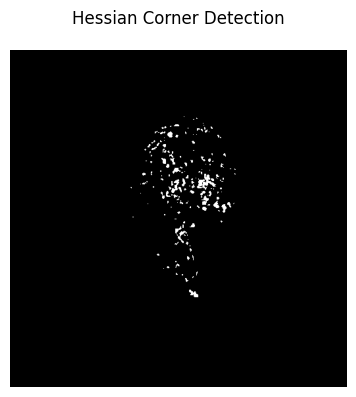

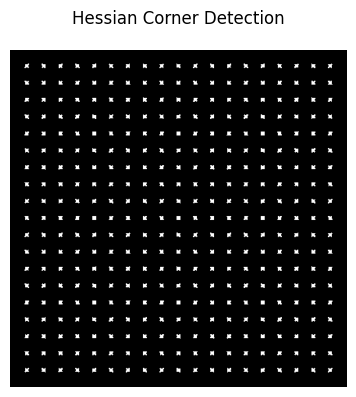

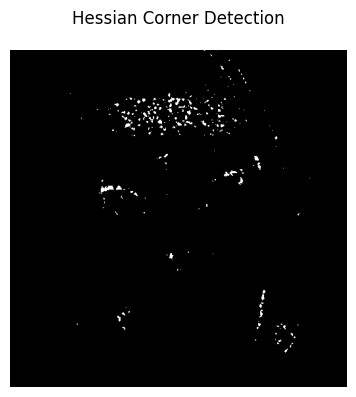

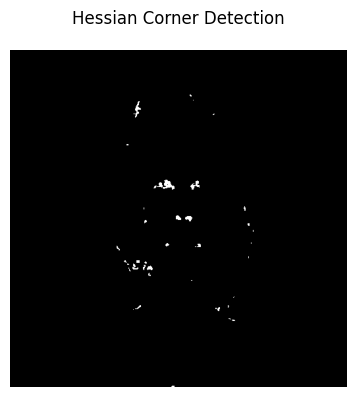

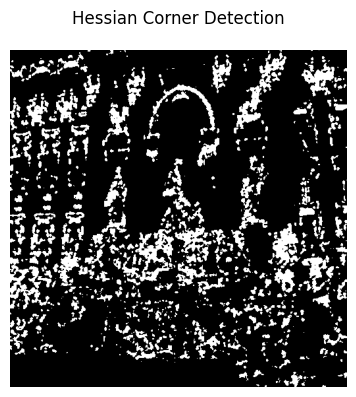

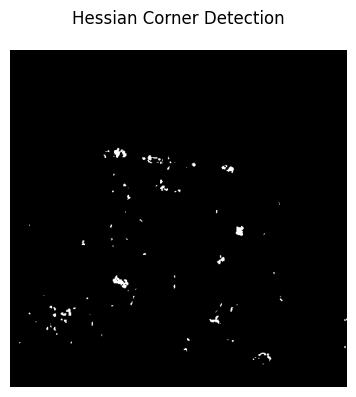

In [ ]:
for image in gt_images:
    corner_image = detect_harris_corner(image, threshold=0.01, window_size=5)
    show_image_grid(np.array([corner_image]), 1, 1, 'Hessian Corner Detection', figsize=16)